## Concept implemented in this notebook taken from Building Effective agent By anthropic

    Link:   https://www.anthropic.com/engineering/building-effective-agents

## Prompt Chaining

In [3]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict,Dict, Any,List,Annotated
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import operator

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
import os
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage,AIMessage

load_dotenv()
groq_api_key  = os.getenv("GROQ_API_KEY")
if not groq_api_key:
    raise ValueError("GROQ_API_KEY not found in environment")

In [5]:
llm = ChatOpenAI(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_tokens=8192,
    api_key=groq_api_key,
    base_url = "https://api.groq.com/openai/v1"
)

In [11]:
class JokeClass(TypedDict):
    topic:str
    joke:str
    imporved_joke:str
    final_joke:str

In [ ]:
def generate_joke(state:JokeClass) -> Dict[str,Any]:
    topic = state["topic"]
    prompt = f"This is the topic: {topic} , make a Joke from it"
    msg = llm.invoke(prompt)
    return {"joke":msg.content}

def improve_joke(state:JokeClass) -> Dict[str,Any]:
    Joke = state["joke"]
    prompt = f"make this Joke : {Joke} , funnier by adding wordplay"
    msg = llm.invoke(prompt)

    return {"imporved_joke":msg.content}
def polish_joke(state:JokeClass) -> Dict[str,Any]:
    imp_joke = state["imporved_joke"]
    prompt = f"add a supprising twist to this joke: {imp_joke}"
    msg = llm.invoke(prompt)

    return {"final_joke":msg.content}

def check_punchline(state:JokeClass)-> Dict[str,Any]:
    if "?" in state["joke"] or "!" in  state["joke"]:
        return "Pass"
    return "Fail"

In [13]:
graph = StateGraph(JokeClass)
graph.add_node("generate_joke",generate_joke)
graph.add_node("improve_joke",improve_joke)
graph.add_node("polish_joke",polish_joke)

graph.add_edge(START,"generate_joke")
graph.add_conditional_edges("generate_joke",check_punchline, {"Pass":"improve_joke","Fail":END})
graph.add_edge("improve_joke","polish_joke")
graph.add_edge("polish_joke",END)

workflow = graph.compile()
workflow.invoke({"topic":"recaptcha"})

{'topic': 'recaptcha',
 'joke': 'Sure, here’s a light‑hearted one:\n\n> **Why did the website break up with its reCAPTCHA?**  \n> Because every time it tried to get close, the reCAPTCHA kept saying, “I’m not a robot… but I’m still not feeling it!”',
 'imporved_joke': '**Why did the website dump its reCAPTCHA?**  \n\nBecause every time it tried to get *close*—or even just *click*—the reCAPTCHA kept throwing a “*human* error”:  \n\n> “I’m not a robot, but I’m still not *feeling* the *connection*—you’re just too *script‑y* for me!”  \n\n*Bonus wordplay:* The site tried to *debug* the relationship, but the reCAPTCHA kept insisting it needed *more *CAPTCHA*tion* before any *login* could happen.',
 'final_joke': "**Why did the website dump its reCAPTCHA?**  \n\nBecause every time it tried to get *close*—or even just *click*—the reCAPTCHA kept throwing a “*human* error”:  \n\n> “I’m not a robot, but I’m still not *feeling* the *connection*—you’re just too *script‑y* for me!”  \n\n*Bonus wordp

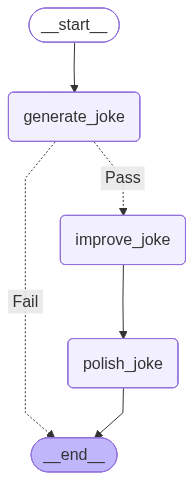

In [14]:
workflow

## Parallelization

In [54]:
from langgraph.graph.message import add_messages


class State(TypedDict):
    topic:str
    Joke:str
    Poem:str
    Story:str
    combined_output:Annotated[list,add_messages]

In [55]:
def generate_joke(state:State) -> Dict[str,Any]:
    topic = state["topic"]
    prompt = f"Generate the joke with this topic: {topic}"
    
    msg = llm.invoke(prompt)

    return {"Joke":msg.content,"combined_output":[msg]}

def generate_poem(state:State) -> Dict[str,Any]:
    topic = state["topic"]
    prompt = f"Generate the Poem with this topic: {topic}"
    
    msg = llm.invoke(prompt)

    return {"Poem":msg.content,"combined_output":[msg]}

def generate_story(state:State) -> Dict[str,Any]:
    topic = state["topic"]
    prompt = f"Generate the story with this topic: {topic}. Maximum 100 words striclty."
    
    msg = llm.invoke(prompt)

    return {"Story":msg.content,"combined_output":[msg]}

def combined_outputs(state:State) -> Dict[str,Any]:
    return {"combined_output":state["combined_output"]}




In [56]:
graph = StateGraph(State)
graph.add_node("generate_joke",generate_joke)
graph.add_node("generate_poem",generate_poem)
graph.add_node("generate_story",generate_story)
graph.add_node("combined_output",combined_outputs)

graph.add_edge(START,"generate_joke")
graph.add_edge(START,"generate_poem")
graph.add_edge(START,"generate_story")
graph.add_edge("generate_joke","combined_output")
graph.add_edge("generate_poem","combined_output")
graph.add_edge("generate_story","combined_output")
graph.add_edge("combined_output",END)

In [57]:
workflow = graph.compile()

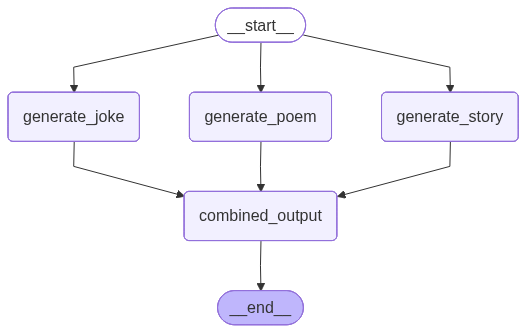

In [58]:
workflow

In [59]:
workflow.invoke({"topic":"pizza"})

{'topic': 'pizza',
 'Joke': 'Why did the pizza apply for a job?\n\nBecause it heard the company was looking for someone with a lot of *dough* and great *delivery* skills! 🍕😄',
 'Poem': '**Ode to the Circle of Delight**\n\nIn a humble oven’s amber glow,  \nA doughy moon begins to rise,  \nIts fragrant sighs of yeast‑kissed air  \nInvite the world to close its eyes.\n\nA ruby river, sauce, spreads wide—  \nTomatoes crushed, a sun‑kissed tide,  \nGarlic whispers, basil sighs,  \nA fragrant promise, deep inside.\n\nThen cheese, a snowy blanket soft,  \nMelted rivers, golden streams,  \nStretching ribbons, pulling hearts,  \nA molten hug of dairy dreams.\n\nPepperoni moons, crisp‑edged stars,  \nMushroom caps like forest crowns,  \nOlives black as midnight’s wink,  \nAnd peppers bright as sunrise towns.\n\nThe crust, a sturdy, caramel crust,  \nA crunch that sings of grain and fire,  \nA sturdy base for all that rides—  \nA canvas for the chef’s desire.\n\nSlice by slice, the world unites, 

## Routing

In [61]:
from typing import Literal
from pydantic import BaseModel,Field
class Route(BaseModel):
    intent : Literal["poem","story","joke"] = Field(None,description="The next step in the routing process")


route = llm.with_structured_output(Route)